1. Считать в `pandas.DataFrame` любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.
   > Датасет должен содержать категориальные и количественные признаки.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('heart.csv')

print(df.head())
print(df.info())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age    

2. Датасет и подготовка данных:
   - Привести описание датасета.
   - Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".
   - Нормализовать численные данные.
   - Разбить выборку на обучающую и тестовую.
     > Из датафреймов обучающей и тестовой выборки необходимо сформировать два набора обучающей и тестовой выборок: с закодированными категориальными признаками и с категориальными признаками без обработки.

In [ ]:
print("Описание датасета:")
print(df.describe(include='all'))

print("\nПроверка пропусков:")
print(df.isnull().sum())

df = df.drop_duplicates()

X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X_processed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Описание датасета:
               Age  Sex ChestPainType   RestingBP  Cholesterol   FastingBS  \
count   918.000000  918           918  918.000000   918.000000  918.000000   
unique         NaN    2             4         NaN          NaN         NaN   
top            NaN    M           ASY         NaN          NaN         NaN   
freq           NaN  725           496         NaN          NaN         NaN   
mean     53.510893  NaN           NaN  132.396514   198.799564    0.233115   
std       9.432617  NaN           NaN   18.514154   109.384145    0.423046   
min      28.000000  NaN           NaN    0.000000     0.000000    0.000000   
25%      47.000000  NaN           NaN  120.000000   173.250000    0.000000   
50%      54.000000  NaN           NaN  130.000000   223.000000    0.000000   
75%      60.000000  NaN           NaN  140.000000   267.000000    0.000000   
max      77.000000  NaN           NaN  200.000000   603.000000    1.000000   

       RestingECG       MaxHR ExerciseAngina

3. Для каждого из классификаторов ($AdaBoost$, $GradientBoostingClassifier$, $XGBoost$, $CatBoost$):
   - С использованием `GridSearchCV`/`grid_search` осуществить подбор гиперпараметра модели, использовать выборки с закодированными категориальными признаками.
     > Как минимум основных: `n_estimators`/`iterations`, `learning_rate`, `depth`, параметры регуляризации $L^1$, $L^2$. Для ускорения вычислений можно сразу с заданным значением `early_stopping_rounds` &ndash; тогда понадобится еще выделить валидационный датасет ($XGBoost$) или задать значение `train_size` у $CatBoost$ (часть обучающей выборки пойдет в валидационный набор).
   - Обучить модели $XGBoost$ и $CatBoost$ с найденными гиперпараметрами на обучающей выборке с категориальными признаками "как есть".
   - Итого получить 6 обученных моделей.
   - Вывести метрики на тестовом наборе (как минимум `classification_report`, другие по желанию).
   - Сравнить модели, выбрать лучшую.
     > Ожидаемый результат &ndash; $XGBoost$/$CatBoost$.

In [ ]:
def hyperparameter_search(model, param_grid, X_train, y_train, cv=5):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print(f"Лучшие параметры: {grid_search.best_params_}")
    return best_model

In [ ]:
ada = AdaBoostClassifier()
param_grid_ada = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.5, 1.0]
}
best_ada = hyperparameter_search(ada, param_grid_ada, X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие параметры: {'learning_rate': 0.5, 'n_estimators': 100}


In [ ]:
ada = AdaBoostClassifier()
param_grid_ada = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.5, 1.0]
}
best_ada = hyperparameter_search(ada, param_grid_ada, X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие параметры: {'learning_rate': 0.5, 'n_estimators': 100}


In [ ]:
gb = GradientBoostingClassifier()
param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5],
    'min_samples_split': [2, 4]
}
best_gb = hyperparameter_search(gb, param_grid_gb, X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}
best_xgb = hyperparameter_search(xgb_clf, param_grid_xgb, X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1}


In [ ]:
catboost = CatBoostClassifier(silent=True)
param_grid_cat = {
    'iterations': [100, 200],
    'learning_rate': [0.1, 0.05],
    'depth': [3, 5],
    'l2_leaf_reg': [0, 0.1]
}
best_cat = hyperparameter_search(catboost, param_grid_cat, X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие параметры: {'depth': 5, 'iterations': 200, 'l2_leaf_reg': 0.1, 'learning_rate': 0.05}


In [ ]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

categorical_cols = X_train_raw.select_dtypes(include='object').columns
X_train_raw[categorical_cols] = X_train_raw[categorical_cols].astype('category')
X_test_raw[categorical_cols] = X_test_raw[categorical_cols].astype('category')

xgb_raw = XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)
xgb_raw.fit(X_train_raw, y_train_raw)

cat_raw = CatBoostClassifier(silent=True)
cat_raw.fit(X_train_raw, y_train_raw, cat_features=list(categorical_cols))

In [ ]:
models = {
    'AdaBoost': best_ada,
    'GradientBoosting': best_gb,
    'XGBoost_encoded': best_xgb,
    'CatBoost_encoded': best_cat,
    'XGBoost_raw': xgb_raw,
    'CatBoost_raw': cat_raw
}

In [ ]:
from sklearn.metrics import classification_report

for name, model in models.items():
    try:
        X_test_used = X_test if 'encoded' in name or 'Ada' in name or 'Gradient' in name else X_test_raw
        y_pred = model.predict(X_test_used)
        print(f"\n{name}:\n{classification_report(y_test, y_pred)}")
    except Exception as e:
        print(f"{name}: Ошибка в предсказании - {e}")


AdaBoost:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        82
           1       0.90      0.91      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184


GradientBoosting:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        82
           1       0.90      0.90      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184


XGBoost_encoded:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87        82
           1       0.90      0.89      0.90       102

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89   

4. Важность признаков:
   - С использованием `shap.TreeExplainer` получить $SHAP$-значения для лучшей модели.
   - Построить график `shap.plots.force` для одного объекта выборки и для среза произвольного размера.
   - Построить график `shap.plots.bar` для одного объекта выборки.
   - Построить график `shap.plots.waterfall` для одного объекта выборки.
   - Построить 2 графика `shap.plots.scatter` для какого-нибудь признака. На одном раскрасить относительно себя, на втором &ndash; относительно другого признака.
   - Построить график `shap.plots.beeswarm` для всех признаков.
   - Построить график `shap.plots.bar` для всех признаков.
   - На основании двух последних графиков и/или используя `feature_importance` отфильровать признаки (отразить сформулированные выводы в тексте), переобучить лучшую модель.
   - Сравнить метрики до и после фильтрации.
   - Визуализировать полученное дерево решений.

In [ ]:
import shap

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):
    print("Многоклассовая задача или бинарная с разделением")
else:
    print("Бинарная задача, shap_values — плоский массив")

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
encoded_cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names_for_shap = numeric_features + list(encoded_cat_names)

X_single = X_test[0]

if isinstance(shap_values, list):
    shap_values_single = shap_values[1][0]
    base_value = explainer.expected_value
else:
    shap_values_single = shap_values[0]
    base_value = explainer.expected_value

explanation = shap.Explanation(
    values=shap_values_single,
    base_values=base_value,
    data=X_single,
    feature_names=feature_names_for_shap
)

shap.initjs()
shap.plots.force(explanation)

Бинарная задача, shap_values — плоский массив


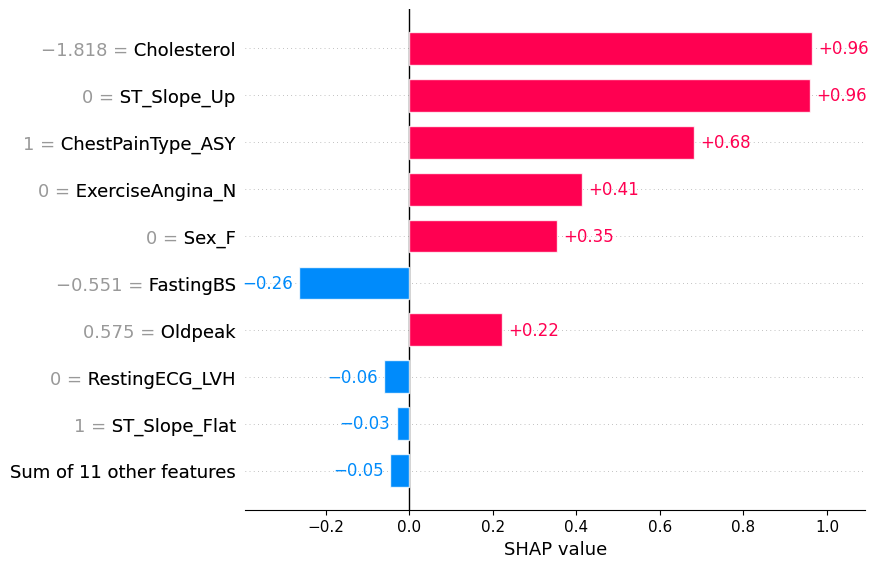

In [ ]:
shap.plots.bar(explanation)

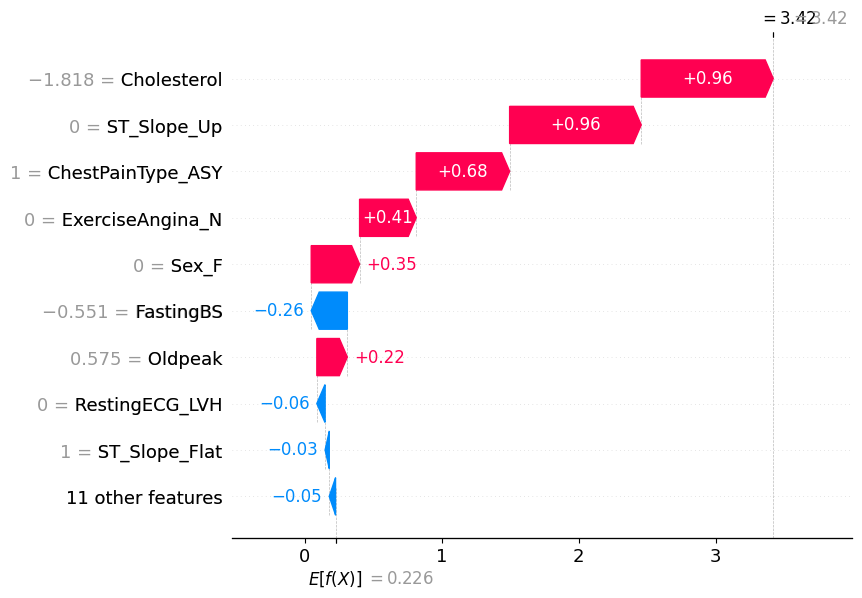

In [ ]:
shap.plots.waterfall(explanation)

5. Регрессия:
   - С использованием `GridSearchCV`/`grid_search` осуществить подбор гиперпараметра модели линейной регрессии с использованием $XGBoost$ или $CatBoost$.
     > [xgboost.XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) в $XGBoost$, [CatBoostRegressor](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor) в $CatBoost$. В целом, можно выбрать новый таргет из уже полученного разбиения на обучающую и тестовыую выборки из пункта 2.
   - Вывести метрики $MSE$, $MAE$ и $R^2$ на тестовом наборе.
   - Переобучить модель на отфильтрованном наборе признаков из пункта 4.
   - Сравнить метрики до и после фильтрации.

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

print("Колонки в df:", df.columns.tolist())

target_col = 'MaxHR'

X_reg = df.drop(columns=[target_col])
y_reg = df[target_col]

numeric_features_reg = X_reg.select_dtypes(include=np.number).columns.tolist()
categorical_features_reg = X_reg.select_dtypes(exclude=np.number).columns.tolist()

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_reg),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_reg)
    ])

X_reg_processed = preprocessor_reg.fit_transform(X_reg)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg_processed, y_reg, test_size=0.2, random_state=42
)


model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train_r, y_train_r)

y_pred = model.predict(X_test_r)

print("MSE:", mean_squared_error(y_test_r, y_pred))
print("R^2:", r2_score(y_test_r, y_pred))

Колонки в df: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']
MSE: 485.0695495605469
R^2: 0.27257221937179565
